In [2]:
import pandas as pd
import numpy as np
from keras.models import Model, load_model
from keras.layers import LSTM, Dense, Dropout, Input, Conv1D, Flatten, concatenate
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Definir look_back
look_back = 6  

# Cargar el archivo y eliminar filas donde el clúster es NaN
file_path = 'data/data.csv'   # Cambia esta ruta al archivo que has subido
data = pd.read_csv(file_path)
data = data.dropna(subset=['Cluster_Label'])

# Convertir 'year' y 'month_no' a una sola columna de tipo fecha
data['date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month_no'].astype(str))

# Seleccionar las columnas necesarias para la serie temporal
columns_to_keep = ['date', 'species', 'Cluster_Label', 'landed_w_kg', 
                   '0.49402499_m', '1.541375_m', '2.645669_m', '3.819495_m', '5.0782242_m',
                   '6.4406142_m', '7.9295602_m', '9.5729971_m', 'mean_temp']
data = data[columns_to_keep]


2024-07-02 19:01:58.653888: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-02 19:01:58.657183: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-02 19:01:58.701968: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 19:01:58.701995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 19:01:58.703394: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
# Función para preparar los datos
def prepare_data(group, look_back=6):
    features = ['landed_w_kg','Cluster_Label', '0.49402499_m', '1.541375_m', '2.645669_m', '3.819495_m', 
                '5.0782242_m', '6.4406142_m', '7.9295602_m', '9.5729971_m', 'mean_temp']
    scaler = MinMaxScaler(feature_range=(0, 1))
    group_scaled = scaler.fit_transform(group[features])
    
    X, y = [], []
    for i in range(len(group_scaled) - look_back):
        a = group_scaled[i:(i + look_back)]
        X.append(a)
        y.append(group_scaled[i + look_back, 0])  # La primera columna es 'landed_w_kg'
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))
    return X, y, scaler

# Crear el modelo LSTM
def create_lstm_model(input_shape):
    lstm_input = Input(shape=input_shape)
    x = LSTM(50, return_sequences=True)(lstm_input)
    x = Dropout(0.2)(x)
    x = LSTM(25, activation='relu', return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(12, activation='linear')(x)
    lstm_output = Dense(1, activation='linear')(x)
    return Model(inputs=lstm_input, outputs=lstm_output)

# Crear el modelo DNN
def create_dnn_model(input_shape):
    dnn_input = Input(shape=(input_shape[0], input_shape[1]))
    x = Flatten()(dnn_input)
    x = Dense(10, activation='relu')(x)
    x = Dense(5, activation='relu')(x)
    dnn_output = Dense(1, activation='linear')(x)
    return Model(inputs=dnn_input, outputs=dnn_output)

# Crear el modelo CNN
def create_cnn_model(input_shape):
    cnn_input = Input(shape=input_shape)
    x = Conv1D(32, kernel_size=3, activation='relu')(cnn_input)
    x = Flatten()(x)
    cnn_output = Dense(1, activation='linear')(x)
    return Model(inputs=cnn_input, outputs=cnn_output)

# Crear el modelo Mixture of Experts (MoE)
def create_moe_model(input_shape):
    # Definir los expertos
    lstm_model = create_lstm_model(input_shape)
    dnn_model = create_dnn_model(input_shape)
    cnn_model = create_cnn_model(input_shape)
    
    # Definir el gating network
    moe_input = Input(shape=input_shape)
    x = Flatten()(moe_input)
    x = Dense(10, activation='relu')(x)
    gate_output = Dense(3, activation='softmax')(x)  # Tres expertos

    # Obtener las salidas de los expertos
    lstm_output = lstm_model(moe_input)
    dnn_output = dnn_model(moe_input)
    cnn_output = cnn_model(moe_input)
    
    # Combinar las salidas usando el gating network
    output = concatenate([lstm_output * gate_output[:, 0:1],
                          dnn_output * gate_output[:, 1:2],
                          cnn_output * gate_output[:, 2:3]], axis=1)
    output = Dense(1, activation='linear')(output)
    
    model = Model(inputs=moe_input, outputs=output)
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model


In [4]:
# Función para entrenar y guardar el modelo MoE
def train_and_save_moe_model(data, species_name, cluster_label, look_back=look_back, epochs=50, batch_size=1):
    X, y, scaler = prepare_data(data, look_back)
    model = create_moe_model((look_back, X.shape[2]))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    history = model.fit(X, y, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])
    
    # Guardar el modelo y el scaler
    model_directory = 'modelos_moe'
    os.makedirs(model_directory, exist_ok=True)
    model_path = os.path.join(model_directory, f'{species_name}_cluster_{cluster_label}_moe_model.h5')
    scaler_path = os.path.join(model_directory, f'{species_name}_cluster_{cluster_label}_moe_scaler.pkl')
    model.save(model_path)
    joblib.dump(scaler, scaler_path)
    
    # Guardar los valores de monitoreo del entrenamiento
    train_moe_directory = 'train_moe'
    os.makedirs(train_moe_directory, exist_ok=True)
    history_path = os.path.join(train_moe_directory, f'{species_name}_cluster_{cluster_label}_training_history.csv')
    pd.DataFrame(history.history).to_csv(history_path, index=False)
    
    print(f'Modelo MoE, scaler y datos de entrenamiento guardados para {species_name} en clúster {cluster_label}')
    return model, scaler

# Función para hacer predicciones con bandas de confianza usando bootstrap
def predict_with_confidence_intervals(model, scaler, data, look_back=6, n_bootstrap=100, alpha=0.01):
    features = ['landed_w_kg','Cluster_Label', '0.49402499_m', '1.541375_m', '2.645669_m', '3.819495_m', 
                '5.0782242_m', '6.4406142_m', '7.9295602_m', '9.5729971_m', 'mean_temp']
    group_scaled = scaler.transform(data[features])

    X = []
    for i in range(len(group_scaled) - look_back):
        a = group_scaled[i:(i + look_back)]
        X.append(a)
    X = np.array(X)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))
    
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(np.hstack((predictions, X[:, -1, 1:])))[:, 0]
    
    # Bootstrap para bandas de confianza
    bootstrap_predictions = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(range(len(X)), len(X), replace=True)
        X_sample = X[indices]
        pred_sample = model.predict(X_sample)
        pred_sample = scaler.inverse_transform(np.hstack((pred_sample, X_sample[:, -1, 1:])))[:, 0]
        bootstrap_predictions.append(pred_sample)
    
    bootstrap_predictions = np.array(bootstrap_predictions)
    lower_bound = np.percentile(bootstrap_predictions, 100 * alpha / 2, axis=0)
    upper_bound = np.percentile(bootstrap_predictions, 100 * (1 - alpha / 2), axis=0)
    
    return predictions, lower_bound, upper_bound



In [6]:
# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Definir la especie y clúster desde donde retomar el proceso y detenerlo
start_species = 'JAIBA'
start_cluster = 2.0
stop_species = 'CHARAL'
stop_cluster = 0.0

# Inicializar banderas
start_training = False
stop_training = False

for species_name in unique_species:
    for cluster_label in unique_clusters:
        # Activar la bandera cuando se alcance la especie y clúster deseados para iniciar
        if species_name == start_species and cluster_label == start_cluster:
            start_training = True
        
        # Detener el proceso cuando se alcance la especie y clúster deseados para detener
        if species_name == stop_species and cluster_label == stop_cluster:
            stop_training = True
        
        # Continuar solo si la bandera de inicio está activada y la de detener no lo está
        if start_training and not stop_training:
            # Filtrar los datos para obtener una especie y un clúster específico
            filtered_data = data[(data['species'] == species_name) & (data['Cluster_Label'] == cluster_label)]
            
            if len(filtered_data) >= look_back:
                filtered_data = filtered_data.sort_values('date')
                try:
                    print(f'Training model for species: {species_name}, cluster: {cluster_label}')
                    model, scaler = train_and_save_moe_model(filtered_data, species_name, cluster_label, look_back)

                    # Guardar los datos para las bandas de confianza
                    test_data_2023 = filtered_data[(filtered_data['date'].dt.year == 2023) & (filtered_data['date'].dt.month >= 1)]
                    if len(test_data_2023) >= look_back:
                        predictions, lower_bound, upper_bound = predict_with_confidence_intervals(model, scaler, test_data_2023, look_back)
                        real_values = test_data_2023['landed_w_kg'].values[look_back:]
                        
                        # Crear un DataFrame para los resultados
                        results_df = pd.DataFrame({
                            'date': test_data_2023['date'].values[look_back:],
                            'real_values': real_values,
                            'predictions': predictions,
                            'lower_bound': lower_bound,
                            'upper_bound': upper_bound
                        })
                        
                        # Guardar los resultados
                        results_directory = 'resultados_moe'
                        os.makedirs(results_directory, exist_ok=True)
                        results_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_predictions.csv')
                        results_df.to_csv(results_path, index=False)
                        
                        # Agrupar por mes y sumar los valores
                        monthly_totals = results_df.set_index('date').resample('M').sum()
                        
                        # Calcular MSE y R2 para los totales mensuales
                        mse = mean_squared_error(monthly_totals['real_values'], monthly_totals['predictions'])
                        r2 = r2_score(monthly_totals['real_values'], monthly_totals['predictions'])
                        print(f'MSE Mensual para {species_name} en clúster {cluster_label}: {mse}, R2 Mensual: {r2}')
                        
                        # Crear figura
                        plt.figure(figsize=(10, 6))
                        plt.plot(monthly_totals.index, monthly_totals['real_values'], color='blue', label='Real')
                        plt.plot(monthly_totals.index, monthly_totals['predictions'], color='red', linestyle='--', label='Predicho')
                        plt.fill_between(monthly_totals.index, monthly_totals['lower_bound'], monthly_totals['upper_bound'], color='gray', alpha=0.2, label='Intervalo de Confianza 95%')
                        plt.title(f'Totales Mensuales de {species_name} en clúster {cluster_label} para los Últimos Seis Meses de 2023')
                        plt.xlabel('Fecha')
                        plt.ylabel('Peso Desembarcado (kg)')
                        plt.legend()
                        plot_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_plot.png')
                        plt.savefig(plot_path)
                        plt.close()
                    else:
                        print(f'No se tienen datos suficientes para {species_name} en clúster {cluster_label} en los últimos seis meses de 2023')
                except Exception as e:
                    print(f'Error entrenando el modelo para especie: {species_name}, clúster: {cluster_label}. Error: {e}')
        
        # Salir del bucle si se alcanza el punto de detener
        if stop_training:
            break
    if stop_training:
        break

Training model for species: JAIBA, cluster: 2.0
Epoch 1/50
15/15 [==============================] - 5s 62ms/step - loss: 0.0846 - val_loss: 9.4068e-04
Epoch 2/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0673 - val_loss: 0.0020
Epoch 3/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0627 - val_loss: 0.0032
Epoch 4/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0596 - val_loss: 0.0031
Epoch 5/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0591 - val_loss: 0.0052
Epoch 6/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0562 - val_loss: 0.0052
Epoch 7/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0549 - val_loss: 0.0050
Epoch 8/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0550 - val_loss: 0.0070
Epoch 9/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0534 - val_loss: 0.0060
Epoch 10/50
15/15 [==============================] - 0s 8ms/step 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 20ms/step
MSE Mensual para JAIBA en clúster 2.0: 267408.7978151947, R2 Mensual: -53.573224043917286


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: JAIBA, cluster: 1.0
Epoch 1/50
42246/42246 [==============================] - 243s 6ms/step - loss: 4.3610e-05 - val_loss: 8.2061e-06
Epoch 2/50
42246/42246 [==============================] - 235s 6ms/step - loss: 3.4068e-05 - val_loss: 7.8375e-06
Epoch 3/50
42246/42246 [==============================] - 231s 5ms/step - loss: 3.3897e-05 - val_loss: 8.2992e-06
Epoch 4/50
42246/42246 [==============================] - 244s 6ms/step - loss: 3.4177e-05 - val_loss: 9.0594e-06
Epoch 5/50
42246/42246 [==============================] - 243s 6ms/step - loss: 3.4084e-05 - val_loss: 8.0818e-06
Epoch 6/50
42246/42246 [==============================] - 238s 6ms/step - loss: 3.3951e-05 - val_loss: 7.7989e-06
Epoch 7/50
42246/42246 [==============================] - 233s 6ms/step - loss: 3.3848e-05 - val_loss: 8.6542e-06
Epoch 8/50
42246/42246 [==============================] - 236s 6ms/step - loss: 3.4034e-05 - val_loss: 1.2342e-05
Epoch 9/50
42246/42246 [================

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


373/373 [==============================] - 1s 3ms/step


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


MSE Mensual para JAIBA en clúster 1.0: 128431217934.70198, R2 Mensual: 0.8619450964567086
Training model for species: JAIBA, cluster: 4.0
Epoch 1/50
682/682 [==============================] - 8s 6ms/step - loss: 0.0060 - val_loss: 0.0024
Epoch 2/50
682/682 [==============================] - 3s 5ms/step - loss: 0.0056 - val_loss: 0.0025
Epoch 3/50
682/682 [==============================] - 3s 5ms/step - loss: 0.0057 - val_loss: 0.0024
Epoch 4/50
682/682 [==============================] - 3s 5ms/step - loss: 0.0055 - val_loss: 0.0030
Epoch 5/50
682/682 [==============================] - 3s 5ms/step - loss: 0.0056 - val_loss: 0.0025
Epoch 6/50
682/682 [==============================] - 3s 5ms/step - loss: 0.0056 - val_loss: 0.0036
Epoch 7/50
682/682 [==============================] - 3s 5ms/step - loss: 0.0056 - val_loss: 0.0025
Epoch 8/50
682/682 [==============================] - 3s 5ms/step - loss: 0.0057 - val_loss: 0.0025
Epoch 9/50
682/682 [==============================] - 3s 5ms/s

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 0s 3ms/step
MSE Mensual para JAIBA en clúster 4.0: 113135091.71330324, R2 Mensual: 0.8810050329577762


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: LISA, cluster: 7.0
Epoch 1/50
3632/3632 [==============================] - 22s 5ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 2/50
3632/3632 [==============================] - 18s 5ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 3/50
3632/3632 [==============================] - 18s 5ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 4/50
3632/3632 [==============================] - 18s 5ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 5/50
3632/3632 [==============================] - 18s 5ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 6/50
3632/3632 [==============================] - 18s 5ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 7/50
3632/3632 [==============================] - 18s 5ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 8/50
3632/3632 [==============================] - 18s 5ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 9/50
3632/3632 [==============================] - 18s 5ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 10/50
3632/3632 [===

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 0s 3ms/step
MSE Mensual para LISA en clúster 7.0: 6723175.727649027, R2 Mensual: 0.9060326052430656


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: LISA, cluster: 0.0
Epoch 1/50
34/34 [==============================] - 5s 26ms/step - loss: 0.0450 - val_loss: 0.0054
Epoch 2/50
34/34 [==============================] - 0s 6ms/step - loss: 0.0403 - val_loss: 0.0141
Epoch 3/50
34/34 [==============================] - 0s 6ms/step - loss: 0.0355 - val_loss: 0.0060
Epoch 4/50
34/34 [==============================] - 0s 6ms/step - loss: 0.0318 - val_loss: 0.0059
Epoch 5/50
34/34 [==============================] - 0s 6ms/step - loss: 0.0253 - val_loss: 0.0214
Epoch 6/50
34/34 [==============================] - 0s 6ms/step - loss: 0.0242 - val_loss: 0.0095
Epoch 7/50
34/34 [==============================] - 0s 6ms/step - loss: 0.0221 - val_loss: 0.0071
Epoch 8/50
34/34 [==============================] - 0s 6ms/step - loss: 0.0198 - val_loss: 0.0126
Epoch 9/50
34/34 [==============================] - 0s 6ms/step - loss: 0.0187 - val_loss: 0.0065
Epoch 10/50
34/34 [==============================] - 0s 6ms/step - los

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 19ms/step
MSE Mensual para LISA en clúster 0.0: 338871.36890356545, R2 Mensual: -520.1401290327804


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: LISA, cluster: 3.0
Epoch 1/50
9529/9529 [==============================] - 50s 5ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 2/50
9529/9529 [==============================] - 46s 5ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 3/50
9529/9529 [==============================] - 46s 5ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 4/50
9529/9529 [==============================] - 46s 5ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 5/50
9529/9529 [==============================] - 46s 5ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 6/50
9529/9529 [==============================] - 46s 5ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 7/50
9529/9529 [==============================] - 46s 5ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 8/50
9529/9529 [==============================] - 47s 5ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 9/50
9529/9529 [==============================] - 48s 5ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 10/50
9529/9529 [===

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 0s 3ms/step
MSE Mensual para LISA en clúster 3.0: 110703558.48646404, R2 Mensual: 0.5546220005881397


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: LISA, cluster: 6.0
Epoch 1/50
840/840 [==============================] - 9s 6ms/step - loss: 0.0224 - val_loss: 0.0237
Epoch 2/50
840/840 [==============================] - 4s 5ms/step - loss: 0.0178 - val_loss: 0.0240
Epoch 3/50
840/840 [==============================] - 4s 5ms/step - loss: 0.0181 - val_loss: 0.0230
Epoch 4/50
840/840 [==============================] - 4s 5ms/step - loss: 0.0177 - val_loss: 0.0230
Epoch 5/50
840/840 [==============================] - 4s 5ms/step - loss: 0.0178 - val_loss: 0.0234
Epoch 6/50
840/840 [==============================] - 4s 5ms/step - loss: 0.0177 - val_loss: 0.0230
Epoch 7/50
840/840 [==============================] - 4s 5ms/step - loss: 0.0177 - val_loss: 0.0233
Epoch 8/50
840/840 [==============================] - 4s 5ms/step - loss: 0.0179 - val_loss: 0.0232
Epoch 9/50
840/840 [==============================] - 4s 5ms/step - loss: 0.0176 - val_loss: 0.0232
Epoch 10/50
840/840 [==============================] 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 3ms/step
MSE Mensual para LISA en clúster 6.0: 3757120.3231902868, R2 Mensual: 0.8862077669686654


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: LISA, cluster: 5.0
Epoch 1/50
3/3 [==============================] - 4s 345ms/step - loss: 0.4236 - val_loss: 0.4410
Epoch 2/50
3/3 [==============================] - 0s 19ms/step - loss: 0.3703 - val_loss: 0.3583
Epoch 3/50
3/3 [==============================] - 0s 19ms/step - loss: 0.3080 - val_loss: 0.3062
Epoch 4/50
3/3 [==============================] - 0s 18ms/step - loss: 0.2622 - val_loss: 0.2609
Epoch 5/50
3/3 [==============================] - 0s 18ms/step - loss: 0.2157 - val_loss: 0.2327
Epoch 6/50
3/3 [==============================] - 0s 18ms/step - loss: 0.2033 - val_loss: 0.2012
Epoch 7/50
3/3 [==============================] - 0s 18ms/step - loss: 0.2072 - val_loss: 0.1585
Epoch 8/50
3/3 [==============================] - 0s 17ms/step - loss: 0.1897 - val_loss: 0.1300
Epoch 9/50
3/3 [==============================] - 0s 17ms/step - loss: 0.1885 - val_loss: 0.1006
Epoch 10/50
3/3 [==============================] - 0s 17ms/step - loss: 0.1743 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
5/5 [==============================] - 4s 176ms/step - loss: 0.3097 - val_loss: 0.0491
Epoch 2/50
5/5 [==============================] - 0s 12ms/step - loss: 0.2272 - val_loss: 0.0511
Epoch 3/50
5/5 [==============================] - 0s 11ms/step - loss: 0.1797 - val_loss: 0.0664
Epoch 4/50
5/5 [==============================] - 0s 11ms/step - loss: 0.1252 - val_loss: 0.0850
Epoch 5/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0981 - val_loss: 0.1261
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0867 - val_loss: 0.1794
Epoch 7/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0740 - val_loss: 0.2277
Epoch 8/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0569 - val_loss: 0.2521
Epoch 9/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0435 - val_loss: 0.2523
Epoch 10/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0409 - val_loss: 0.2788
Epoch 11/50
5/5 [===========

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
5975/5975 [==============================] - 33s 5ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 2/50
5975/5975 [==============================] - 29s 5ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 3/50
5975/5975 [==============================] - 29s 5ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 4/50
5975/5975 [==============================] - 29s 5ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 5/50
5975/5975 [==============================] - 29s 5ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 6/50
5975/5975 [==============================] - 29s 5ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 7/50
5975/5975 [==============================] - 29s 5ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 8/50
5975/5975 [==============================] - 29s 5ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 9/50
5975/5975 [==============================] - 29s 5ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 10/50
5975/5975 [==============================] - 29s 5ms/step - l

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


43/43 [==============================] - 0s 3ms/step
MSE Mensual para LISA en clúster 1.0: 154822941.84080708, R2 Mensual: 0.9419630615520564


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: LISA, cluster: 4.0
Epoch 1/50
12/12 [==============================] - 4s 67ms/step - loss: 0.0116 - val_loss: 0.2231
Epoch 2/50
12/12 [==============================] - 0s 8ms/step - loss: 0.0100 - val_loss: 0.2078
Epoch 3/50
12/12 [==============================] - 0s 8ms/step - loss: 0.0086 - val_loss: 0.2131
Epoch 4/50
12/12 [==============================] - 0s 8ms/step - loss: 0.0086 - val_loss: 0.2144
Epoch 5/50
12/12 [==============================] - 0s 8ms/step - loss: 0.0085 - val_loss: 0.2060
Epoch 6/50
12/12 [==============================] - 0s 8ms/step - loss: 0.0085 - val_loss: 0.2157
Epoch 7/50
12/12 [==============================] - 0s 7ms/step - loss: 0.0073 - val_loss: 0.2094
Epoch 8/50
12/12 [==============================] - 0s 8ms/step - loss: 0.0074 - val_loss: 0.2008
Epoch 9/50
12/12 [==============================] - 0s 7ms/step - loss: 0.0079 - val_loss: 0.2082
Epoch 10/50
12/12 [==============================] - 0s 7ms/step - los

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
316/316 [==============================] - 6s 7ms/step - loss: 0.0089 - val_loss: 0.0038
Epoch 2/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0079 - val_loss: 0.0043
Epoch 3/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0077 - val_loss: 0.0037
Epoch 4/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0078 - val_loss: 0.0040
Epoch 5/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0076 - val_loss: 0.0038
Epoch 6/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0076 - val_loss: 0.0040
Epoch 7/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0076 - val_loss: 0.0037
Epoch 8/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 9/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0075 - val_loss: 0.0036
Epoch 10/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0075 - val_loss: 0.0041

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 20ms/step
MSE Mensual para CALAMAR en clúster 3.0: 1731732.2198209467, R2 Mensual: 0.6862994361043057


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: CALAMAR, cluster: 6.0
Epoch 1/50
142/142 [==============================] - 5s 10ms/step - loss: 0.0082 - val_loss: 1.9073e-04
Epoch 2/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 2.0038e-04
Epoch 3/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 0.0023
Epoch 4/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 3.7040e-04
Epoch 5/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 0.0013
Epoch 6/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 0.0014
Epoch 7/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 5.2084e-04
Epoch 8/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 5.7011e-04
Epoch 9/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 3.1458e-04
Epoch 10/50
142/142 [====

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 4ms/step
MSE Mensual para CALAMAR en clúster 6.0: 3339253.898051455, R2 Mensual: -2.377761947514851


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: CALAMAR, cluster: 1.0
Epoch 1/50
2739/2739 [==============================] - 18s 5ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 2/50
2739/2739 [==============================] - 13s 5ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 3/50
2739/2739 [==============================] - 13s 5ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 4/50
2739/2739 [==============================] - 13s 5ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 5/50
2739/2739 [==============================] - 13s 5ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 6/50
2739/2739 [==============================] - 13s 5ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 7/50
2739/2739 [==============================] - 13s 5ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 8/50
2739/2739 [==============================] - 13s 5ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 9/50
2739/2739 [==============================] - 13s 5ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 10/50
2739/2739 [

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 3ms/step
MSE Mensual para CALAMAR en clúster 1.0: 283241420.17035294, R2 Mensual: 0.32704099506917217


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: CALAMAR, cluster: 4.0
Error entrenando el modelo para especie: CALAMAR, clúster: 4.0. Error: Training data contains 1 samples, which is not sufficient to split it into a validation and training set as specified by `validation_split=0.2`. Either provide more data, or a different value for the `validation_split` argument.
Training model for species: CARACOL, cluster: 3.0
Epoch 1/50
914/914 [==============================] - 9s 6ms/step - loss: 0.0162 - val_loss: 0.0030
Epoch 2/50
914/914 [==============================] - 4s 5ms/step - loss: 0.0134 - val_loss: 8.6013e-04
Epoch 3/50
914/914 [==============================] - 4s 5ms/step - loss: 0.0138 - val_loss: 0.0066
Epoch 4/50
914/914 [==============================] - 5s 5ms/step - loss: 0.0127 - val_loss: 7.0623e-04
Epoch 5/50
914/914 [==============================] - 4s 5ms/step - loss: 0.0128 - val_loss: 5.1018e-04
Epoch 6/50
914/914 [==============================] - 4s 5ms/step - loss: 0.0120 - val_l

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 0s 3ms/step
MSE Mensual para CARACOL en clúster 3.0: 10058157.63066295, R2 Mensual: 0.38565487619128325


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: CARACOL, cluster: 6.0
Epoch 1/50
4123/4123 [==============================] - 24s 5ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 2/50
4123/4123 [==============================] - 20s 5ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 3/50
4123/4123 [==============================] - 20s 5ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 4/50
4123/4123 [==============================] - 20s 5ms/step - loss: 0.0018 - val_loss: 9.4339e-04
Epoch 5/50
4123/4123 [==============================] - 20s 5ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 6/50
4123/4123 [==============================] - 20s 5ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 7/50
4123/4123 [==============================] - 20s 5ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 8/50
4123/4123 [==============================] - 20s 5ms/step - loss: 0.0017 - val_loss: 8.2571e-04
Epoch 9/50
4123/4123 [==============================] - 20s 5ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 10/50
412

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 0s 3ms/step
MSE Mensual para CARACOL en clúster 6.0: 1044086371.3266183, R2 Mensual: 0.9343364121257532


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: CARACOL, cluster: 5.0
Epoch 1/50
50/50 [==============================] - 5s 20ms/step - loss: 0.0685 - val_loss: 0.1934
Epoch 2/50
50/50 [==============================] - 0s 6ms/step - loss: 0.0641 - val_loss: 0.1981
Epoch 3/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0546 - val_loss: 0.2392
Epoch 4/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0595 - val_loss: 0.2155
Epoch 5/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0518 - val_loss: 0.1886
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0566 - val_loss: 0.2336
Epoch 7/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0526 - val_loss: 0.1979
Epoch 8/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0580 - val_loss: 0.1768
Epoch 9/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0427 - val_loss: 0.2209
Epoch 10/50
50/50 [==============================] - 0s 5ms/step - 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 18ms/step
MSE Mensual para CARACOL en clúster 5.0: 259646551.64796853, R2 Mensual: 0.6474694501284086
Training model for species: CARACOL, cluster: 2.0


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.0371 - val_loss: 1.2157
Epoch 2/50
1/1 [==============================] - 0s 36ms/step - loss: 0.0191 - val_loss: 1.1634
Epoch 3/50
1/1 [==============================] - 0s 34ms/step - loss: 0.0100 - val_loss: 1.1152
Epoch 4/50
1/1 [==============================] - 0s 34ms/step - loss: 0.0019 - val_loss: 1.0707
Epoch 5/50
1/1 [==============================] - 0s 34ms/step - loss: 2.5974e-05 - val_loss: 1.0323
Epoch 6/50
1/1 [==============================] - 0s 34ms/step - loss: 8.2543e-04 - val_loss: 1.0040
Epoch 7/50
1/1 [==============================] - 0s 33ms/step - loss: 0.0040 - val_loss: 0.9884
Epoch 8/50
1/1 [==============================] - 0s 34ms/step - loss: 0.0054 - val_loss: 0.9828
Epoch 9/50
1/1 [==============================] - 0s 31ms/step - loss: 0.0056 - val_loss: 0.9843
Epoch 10/50
1/1 [==============================] - 0s 30ms/step - loss: 0.0067 - val_loss: 0.9923
Epoch 11/50
1/1 [======

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
4085/4085 [==============================] - 24s 5ms/step - loss: 0.0058 - val_loss: 0.0051
Epoch 2/50
4085/4085 [==============================] - 20s 5ms/step - loss: 0.0055 - val_loss: 0.0047
Epoch 3/50
4085/4085 [==============================] - 20s 5ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 4/50
4085/4085 [==============================] - 20s 5ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 5/50
4085/4085 [==============================] - 20s 5ms/step - loss: 0.0051 - val_loss: 0.0047
Epoch 6/50
4085/4085 [==============================] - 20s 5ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 7/50
4085/4085 [==============================] - 20s 5ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 8/50
4085/4085 [==============================] - 20s 5ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 9/50
4085/4085 [==============================] - 20s 5ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 10/50
4085/4085 [==============================] - 20s 5ms/step - l

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 0s 3ms/step
MSE Mensual para CARACOL en clúster 1.0: 283426178.82354593, R2 Mensual: 0.7821986859948677


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: CARACOL, cluster: 4.0
Epoch 1/50
61/61 [==============================] - 11s 128ms/step - loss: 0.1948 - val_loss: 0.0436
Epoch 2/50
61/61 [==============================] - 0s 6ms/step - loss: 0.1316 - val_loss: 0.0383
Epoch 3/50
61/61 [==============================] - 0s 5ms/step - loss: 0.1028 - val_loss: 0.0381
Epoch 4/50
61/61 [==============================] - 0s 6ms/step - loss: 0.0828 - val_loss: 0.0551
Epoch 5/50
61/61 [==============================] - 0s 5ms/step - loss: 0.0883 - val_loss: 0.0465
Epoch 6/50
61/61 [==============================] - 0s 5ms/step - loss: 0.0740 - val_loss: 0.0478
Epoch 7/50
61/61 [==============================] - 0s 5ms/step - loss: 0.0744 - val_loss: 0.0521
Epoch 8/50
61/61 [==============================] - 0s 5ms/step - loss: 0.0700 - val_loss: 0.0472
Epoch 9/50
61/61 [==============================] - 0s 5ms/step - loss: 0.0689 - val_loss: 0.0496
Epoch 10/50
61/61 [==============================] - 0s 5ms/step 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 21ms/step
MSE Mensual para CARACOL en clúster 4.0: 113078.4088561114, R2 Mensual: 0.5664197711185087


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: ALMEJA, cluster: 0.0
Epoch 1/50
30/30 [==============================] - 5s 32ms/step - loss: 0.1161 - val_loss: 0.0075
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0736 - val_loss: 0.0108
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0734 - val_loss: 0.0144
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0715 - val_loss: 0.0077
Epoch 5/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0635 - val_loss: 0.0093
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0592 - val_loss: 0.0115
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0537 - val_loss: 0.0077
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0534 - val_loss: 0.0078
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0564 - val_loss: 0.0077
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - l

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 3ms/step
MSE Mensual para ALMEJA en clúster 0.0: 310382.68719056906, R2 Mensual: 0.824397003046311


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: ALMEJA, cluster: 3.0
Epoch 1/50
2118/2118 [==============================] - 15s 5ms/step - loss: 0.0026 - val_loss: 9.4715e-04
Epoch 2/50
2118/2118 [==============================] - 11s 5ms/step - loss: 0.0026 - val_loss: 7.8964e-04
Epoch 3/50
2118/2118 [==============================] - 11s 5ms/step - loss: 0.0026 - val_loss: 2.2036e-04
Epoch 4/50
2118/2118 [==============================] - 11s 5ms/step - loss: 0.0026 - val_loss: 3.9711e-04
Epoch 5/50
2118/2118 [==============================] - 11s 5ms/step - loss: 0.0026 - val_loss: 2.9784e-04
Epoch 6/50
2118/2118 [==============================] - 10s 5ms/step - loss: 0.0026 - val_loss: 6.2863e-04
Epoch 7/50
2118/2118 [==============================] - 11s 5ms/step - loss: 0.0026 - val_loss: 8.9373e-04
Epoch 8/50
2118/2118 [==============================] - 10s 5ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 9/50
2118/2118 [==============================] - 11s 5ms/step - loss: 0.0025 - val_loss: 2.3

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/35 [==============================] - 0s 3ms/step
MSE Mensual para ALMEJA en clúster 3.0: 811961504.3726438, R2 Mensual: 0.5891516708725938


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: ALMEJA, cluster: 6.0
Epoch 1/50
7692/7692 [==============================] - 43s 5ms/step - loss: 0.0038 - val_loss: 9.4290e-04
Epoch 2/50
7692/7692 [==============================] - 38s 5ms/step - loss: 0.0034 - val_loss: 0.0010
Epoch 3/50
7692/7692 [==============================] - 38s 5ms/step - loss: 0.0033 - val_loss: 9.4811e-04
Epoch 4/50
7692/7692 [==============================] - 38s 5ms/step - loss: 0.0032 - val_loss: 9.7433e-04
Epoch 5/50
7692/7692 [==============================] - 38s 5ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 6/50
7692/7692 [==============================] - 38s 5ms/step - loss: 0.0032 - val_loss: 9.2879e-04
Epoch 7/50
7692/7692 [==============================] - 38s 5ms/step - loss: 0.0031 - val_loss: 0.0010
Epoch 8/50
7692/7692 [==============================] - 38s 5ms/step - loss: 0.0031 - val_loss: 9.2311e-04
Epoch 9/50
7692/7692 [==============================] - 38s 5ms/step - loss: 0.0031 - val_loss: 9.4081e-04


/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 0s 3ms/step
MSE Mensual para ALMEJA en clúster 6.0: 575772240.6447148, R2 Mensual: 0.5874087749237306


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: ALMEJA, cluster: 5.0
Epoch 1/50
852/852 [==============================] - 9s 6ms/step - loss: 0.0262 - val_loss: 0.0110
Epoch 2/50
852/852 [==============================] - 4s 5ms/step - loss: 0.0247 - val_loss: 0.0126
Epoch 3/50
852/852 [==============================] - 4s 5ms/step - loss: 0.0244 - val_loss: 0.0108
Epoch 4/50
852/852 [==============================] - 4s 5ms/step - loss: 0.0240 - val_loss: 0.0151
Epoch 5/50
852/852 [==============================] - 4s 5ms/step - loss: 0.0237 - val_loss: 0.0128
Epoch 6/50
852/852 [==============================] - 4s 5ms/step - loss: 0.0234 - val_loss: 0.0116
Epoch 7/50
852/852 [==============================] - 4s 5ms/step - loss: 0.0234 - val_loss: 0.0132
Epoch 8/50
852/852 [==============================] - 4s 5ms/step - loss: 0.0234 - val_loss: 0.0115
Epoch 9/50
852/852 [==============================] - 4s 5ms/step - loss: 0.0233 - val_loss: 0.0118
Epoch 10/50
852/852 [==============================

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 0s 3ms/step
MSE Mensual para ALMEJA en clúster 5.0: 86484585.05778278, R2 Mensual: 0.6232625123083522
Training model for species: ALMEJA, cluster: 2.0


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
15/15 [==============================] - 5s 58ms/step - loss: 0.0690 - val_loss: 7.7990e-04
Epoch 2/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0660 - val_loss: 8.9629e-04
Epoch 3/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0639 - val_loss: 0.0016
Epoch 4/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0627 - val_loss: 0.0021
Epoch 5/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0607 - val_loss: 0.0015
Epoch 6/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0594 - val_loss: 0.0019
Epoch 7/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0581 - val_loss: 0.0024
Epoch 8/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0570 - val_loss: 0.0014
Epoch 9/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0569 - val_loss: 0.0023
Epoch 10/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0542 - val_loss: 0.0017
Epoch 11/5

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
4223/4223 [==============================] - 25s 5ms/step - loss: 6.9933e-04 - val_loss: 9.9099e-05
Epoch 2/50
4223/4223 [==============================] - 21s 5ms/step - loss: 6.8808e-04 - val_loss: 9.2039e-05
Epoch 3/50
4223/4223 [==============================] - 21s 5ms/step - loss: 6.9055e-04 - val_loss: 8.8705e-05
Epoch 4/50
4223/4223 [==============================] - 21s 5ms/step - loss: 6.8905e-04 - val_loss: 8.9316e-05
Epoch 5/50
4223/4223 [==============================] - 21s 5ms/step - loss: 6.8925e-04 - val_loss: 9.3897e-05
Epoch 6/50
4223/4223 [==============================] - 21s 5ms/step - loss: 6.8819e-04 - val_loss: 9.4492e-05
Epoch 7/50
4223/4223 [==============================] - 21s 5ms/step - loss: 6.8609e-04 - val_loss: 8.8641e-05
Epoch 8/50
4223/4223 [==============================] - 20s 5ms/step - loss: 6.8837e-04 - val_loss: 9.3826e-05
Epoch 9/50
4223/4223 [==============================] - 21s 5ms/step - loss: 6.8864e-04 - val_loss: 1.0289e-04
E

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 0s 3ms/step
MSE Mensual para ALMEJA en clúster 1.0: 378025470.2685892, R2 Mensual: 0.6542757713442591


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: ALMEJA, cluster: 4.0
Epoch 1/50
15/15 [==============================] - 5s 56ms/step - loss: 0.0206 - val_loss: 0.2751
Epoch 2/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0190 - val_loss: 0.2628
Epoch 3/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.2663
Epoch 4/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0144 - val_loss: 0.2637
Epoch 5/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0134 - val_loss: 0.2683
Epoch 6/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0127 - val_loss: 0.2657
Epoch 7/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0123 - val_loss: 0.2640
Epoch 8/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.2735
Epoch 9/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.2631
Epoch 10/50
15/15 [==============================] - 0s 7ms/step - l

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 20ms/step
MSE Mensual para ALMEJA en clúster 4.0: 1896726.5756536776, R2 Mensual: 0.003034651430392832


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: LANGOSTINO, cluster: 7.0
Epoch 1/50
88/88 [==============================] - 5s 13ms/step - loss: 0.0181 - val_loss: 0.0960
Epoch 2/50
88/88 [==============================] - 0s 5ms/step - loss: 0.0157 - val_loss: 0.0959
Epoch 3/50
88/88 [==============================] - 0s 5ms/step - loss: 0.0153 - val_loss: 0.0866
Epoch 4/50
88/88 [==============================] - 0s 5ms/step - loss: 0.0150 - val_loss: 0.0915
Epoch 5/50
88/88 [==============================] - 0s 5ms/step - loss: 0.0155 - val_loss: 0.0906
Epoch 6/50
88/88 [==============================] - 0s 5ms/step - loss: 0.0148 - val_loss: 0.0859
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.0147 - val_loss: 0.0848
Epoch 8/50
88/88 [==============================] - 0s 5ms/step - loss: 0.0145 - val_loss: 0.0855
Epoch 9/50
88/88 [==============================] - 0s 5ms/step - loss: 0.0144 - val_loss: 0.0863
Epoch 10/50
88/88 [==============================] - 0s 5ms/step

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
32/32 [==============================] - 5s 28ms/step - loss: 0.0832 - val_loss: 0.0238
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0875 - val_loss: 0.0047
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0735 - val_loss: 0.0139
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0799 - val_loss: 0.0098
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0756 - val_loss: 0.0141
Epoch 6/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0810 - val_loss: 0.0131
Epoch 7/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0766 - val_loss: 0.0059
Epoch 8/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0709 - val_loss: 0.0043
Epoch 9/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0704 - val_loss: 0.0028
Epoch 10/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0746 - val_loss: 0.0202
Epoch 11/50
32/32 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
49/49 [==============================] - 5s 20ms/step - loss: 0.0402 - val_loss: 0.0818
Epoch 2/50
49/49 [==============================] - 0s 6ms/step - loss: 0.0348 - val_loss: 0.0704
Epoch 3/50
49/49 [==============================] - 0s 5ms/step - loss: 0.0273 - val_loss: 0.0719
Epoch 4/50
49/49 [==============================] - 0s 5ms/step - loss: 0.0267 - val_loss: 0.0648
Epoch 5/50
49/49 [==============================] - 0s 5ms/step - loss: 0.0250 - val_loss: 0.0668
Epoch 6/50
49/49 [==============================] - 0s 5ms/step - loss: 0.0246 - val_loss: 0.0686
Epoch 7/50
49/49 [==============================] - 0s 5ms/step - loss: 0.0213 - val_loss: 0.0709
Epoch 8/50
49/49 [==============================] - 0s 5ms/step - loss: 0.0223 - val_loss: 0.0679
Epoch 9/50
49/49 [==============================] - 0s 5ms/step - loss: 0.0233 - val_loss: 0.0685
Epoch 10/50
49/49 [==============================] - 0s 5ms/step - loss: 0.0207 - val_loss: 0.0771
Epoch 11/50
49/49 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training model for species: LANGOSTINO, cluster: 1.0
Epoch 1/50
26/26 [==============================] - 5s 35ms/step - loss: 0.0801 - val_loss: 0.0855
Epoch 2/50
26/26 [==============================] - 0s 7ms/step - loss: 0.0427 - val_loss: 0.0693
Epoch 3/50
26/26 [==============================] - 0s 6ms/step - loss: 0.0391 - val_loss: 0.0724
Epoch 4/50
26/26 [==============================] - 0s 6ms/step - loss: 0.0409 - val_loss: 0.0720
Epoch 5/50
26/26 [==============================] - 0s 6ms/step - loss: 0.0351 - val_loss: 0.0727
Epoch 6/50
26/26 [==============================] - 0s 6ms/step - loss: 0.0326 - val_loss: 0.0714
Epoch 7/50
26/26 [==============================] - 0s 6ms/step - loss: 0.0386 - val_loss: 0.0730
Epoch 8/50
26/26 [==============================] - 0s 6ms/step - loss: 0.0380 - val_loss: 0.0687
Epoch 9/50
26/26 [==============================] - 0s 6ms/step - loss: 0.0324 - val_loss: 0.0657
Epoch 10/50
26/26 [==============================] - 0s 6ms/step

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training model for species: LEBRANCHA, cluster: 3.0
Error entrenando el modelo para especie: LEBRANCHA, clúster: 3.0. Error: tuple index out of range
Training model for species: LEBRANCHA, cluster: 1.0
Epoch 1/50
144/144 [==============================] - 5s 10ms/step - loss: 0.0306 - val_loss: 0.0165
Epoch 2/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0235 - val_loss: 0.0102
Epoch 3/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0245 - val_loss: 0.0216
Epoch 4/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0236 - val_loss: 0.0272
Epoch 5/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0232 - val_loss: 0.0156
Epoch 6/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0220 - val_loss: 0.0196
Epoch 7/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0216 - val_loss: 0.0244
Epoch 8/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0218 - val_loss: 0.02

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 20ms/step
MSE Mensual para LEBRANCHA en clúster 1.0: 867360.1500449502, R2 Mensual: 0.8359528167382783


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: RUBIA Y VILLAJAIBA, cluster: 1.0
Epoch 1/50
6/6 [==============================] - 4s 141ms/step - loss: 0.1621 - val_loss: 0.0201
Epoch 2/50
6/6 [==============================] - 0s 11ms/step - loss: 0.1407 - val_loss: 0.0386
Epoch 3/50
6/6 [==============================] - 0s 11ms/step - loss: 0.1241 - val_loss: 0.0561
Epoch 4/50
6/6 [==============================] - 0s 10ms/step - loss: 0.1150 - val_loss: 0.0787
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0972 - val_loss: 0.0857
Epoch 6/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0927 - val_loss: 0.1067
Epoch 7/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0865 - val_loss: 0.1176
Epoch 8/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0808 - val_loss: 0.1289
Epoch 9/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0729 - val_loss: 0.1249
Epoch 10/50
6/6 [==============================] - 0s 10ms/step -

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
204/204 [==============================] - 5s 8ms/step - loss: 0.0302 - val_loss: 0.0142
Epoch 2/50
204/204 [==============================] - 1s 5ms/step - loss: 0.0253 - val_loss: 0.0138
Epoch 3/50
204/204 [==============================] - 1s 5ms/step - loss: 0.0244 - val_loss: 0.0133
Epoch 4/50
204/204 [==============================] - 1s 5ms/step - loss: 0.0234 - val_loss: 0.0172
Epoch 5/50
204/204 [==============================] - 1s 5ms/step - loss: 0.0233 - val_loss: 0.0134
Epoch 6/50
204/204 [==============================] - 1s 5ms/step - loss: 0.0229 - val_loss: 0.0153
Epoch 7/50
204/204 [==============================] - 1s 5ms/step - loss: 0.0221 - val_loss: 0.0133
Epoch 8/50
204/204 [==============================] - 1s 5ms/step - loss: 0.0204 - val_loss: 0.0193
Epoch 9/50
204/204 [==============================] - 1s 5ms/step - loss: 0.0221 - val_loss: 0.0136
Epoch 10/50
204/204 [==============================] - 1s 5ms/step - loss: 0.0204 - val_loss: 0.0160

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 19ms/step
MSE Mensual para CHARAL en clúster 7.0: 4446336.901594204, R2 Mensual: 0.4977635345145286


/var/tmp/ipykernel_392121/1746379155.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


In [12]:
import os
import pandas as pd
from sklearn.metrics import r2_score

# Directorio donde se encuentran los archivos de predicciones
results_directory = 'resultados_moe'

# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Inicializar un DataFrame para almacenar los valores de R2
r2_df = pd.DataFrame(index=unique_species, columns=unique_clusters)

# Iterar sobre cada combinación de especie y clúster para cargar las predicciones y calcular el R2
for species_name in unique_species:
    for cluster_label in unique_clusters:
        # Ruta del archivo de predicciones
        results_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_predictions.csv')
        
        # Verificar si el archivo existe
        if os.path.exists(results_path):
            # Cargar los datos de predicciones
            results_df = pd.read_csv(results_path)
            
            # Asegurar que la columna 'date' sea de tipo datetime
            results_df['date'] = pd.to_datetime(results_df['date'])
            
            # Agrupar los resultados por mes y sumar los valores
            monthly_totals = results_df.set_index('date').resample('ME').sum()
            
            # Excluir filas con valores NaN
            monthly_totals = monthly_totals.dropna(subset=['real_values', 'predictions'])
            
            # Calcular el R2 para los totales mensuales, si hay suficientes datos
            if not monthly_totals.empty:
                r2 = r2_score(monthly_totals['real_values'], monthly_totals['predictions'])
                # Almacenar el R2 en el DataFrame
                r2_df.at[species_name, cluster_label] = r2
            else:
                #print(f'Sin datos suficientes para calcular R2 para especie: {species_name}, clúster: {cluster_label}')
                r2_df.at[species_name, cluster_label] = None
        else:
            #print(f'Archivo no encontrado para especie: {species_name}, clúster: {cluster_label}')
            r2_df.at[species_name, cluster_label] = None

# Guardar el DataFrame de R2 en un archivo CSV
r2_output_path = os.path.join(results_directory, 'r2_scores.csv')
r2_df.to_csv(r2_output_path)

print(f'Tabla de R2 guardada en: {r2_output_path}')




/opt/conda/envs/cedo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/conda/envs/cedo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/conda/envs/cedo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/conda/envs/cedo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Tabla de R2 guardada en: resultados_moe/r2_scores.csv


/opt/conda/envs/cedo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/conda/envs/cedo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


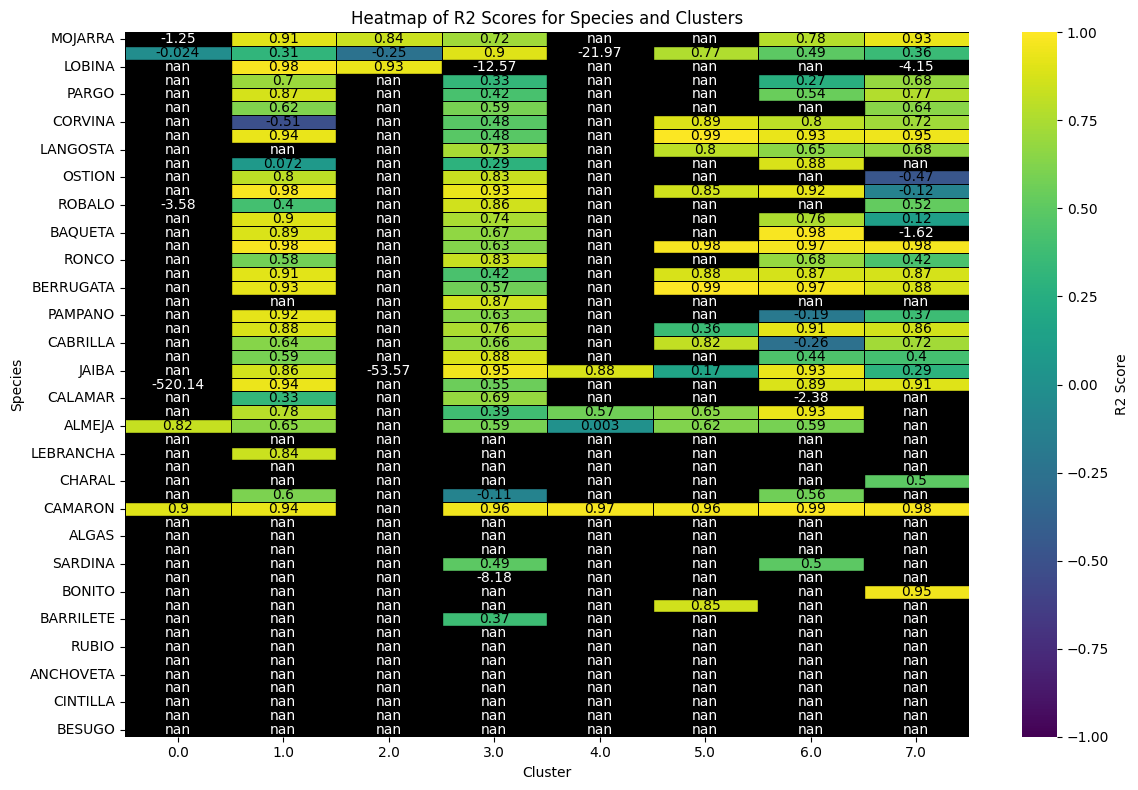

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Definir el orden deseado de las columnas
column_order = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0']

# Asegurar que las columnas estén en formato string y reindexar
r2_df.columns = r2_df.columns.astype(str)
r2_df = r2_df.reindex(columns=column_order)

# Asegurar que el índice también esté en formato string
r2_df.index = r2_df.index.astype(str)

# Reemplazar valores None o NaN con np.nan
r2_df = r2_df.apply(pd.to_numeric, errors='coerce')

# Crear una máscara para los valores fuera del rango [-1, 1]
mask = (r2_df < -1) | (r2_df > 1) | r2_df.isna()

# Crear el mapa de calor
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(r2_df, annot=True, cmap='viridis', cbar_kws={'label': 'R2 Score'}, linewidths=.5, linecolor='black', vmin=-1, vmax=1, mask=mask, annot_kws={"color": "black"})

# Pintar en negro las celdas fuera del rango [-1, 1]
for i in range(r2_df.shape[0]):
    for j in range(r2_df.shape[1]):
        if mask.iloc[i, j]:
            heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black'))
            heatmap.text(j + 0.5, i + 0.5, '{:.2f}'.format(r2_df.iloc[i, j]), ha='center', va='center', color='white')

# Añadir títulos y etiquetas
plt.title('Heatmap of R2 Scores for Species and Clusters')
plt.xlabel('Cluster')
plt.ylabel('Species')

# Mostrar el mapa de calor
plt.tight_layout()
plt.show()



In [16]:
r2_df.to_csv('tabla_resultados.csv')

Sin datos suficientes para calcular r para especie: PARGO, clúster: 0.0
Sin datos suficientes para calcular r para especie: PARGO, clúster: 4.0
Sin datos suficientes para calcular r para especie: LANGOSTA, clúster: 1.0
Sin datos suficientes para calcular r para especie: LENGUADO, clúster: 2.0
Sin datos suficientes para calcular r para especie: ERIZO, clúster: 3.0
Sin datos suficientes para calcular r para especie: SARGAZO, clúster: 3.0


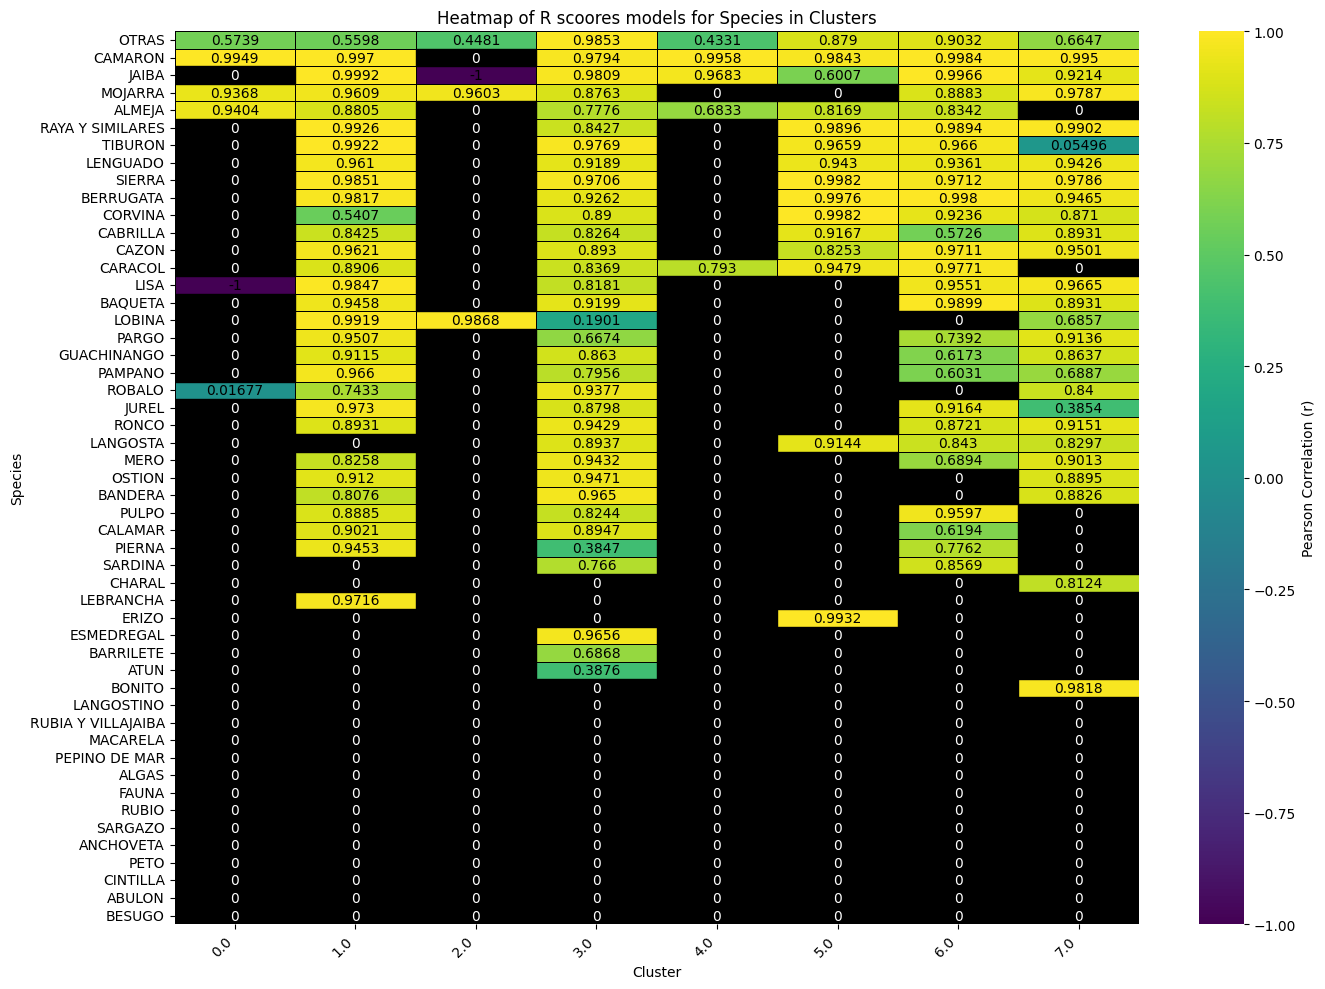

In [26]:
import os
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Directorio donde se encuentran los archivos de predicciones
results_directory = 'resultados_moe'

# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Inicializar un DataFrame para almacenar los valores de r
r_df = pd.DataFrame(index=unique_species, columns=unique_clusters)

# Iterar sobre cada combinación de especie y clúster para cargar las predicciones y calcular r
for species_name in unique_species:
    for cluster_label in unique_clusters:
        # Ruta del archivo de predicciones
        results_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_predictions.csv')
        
        # Verificar si el archivo existe
        if os.path.exists(results_path):
            # Cargar los datos de predicciones
            results_df = pd.read_csv(results_path)
            
            # Asegurar que la columna 'date' sea de tipo datetime
            results_df['date'] = pd.to_datetime(results_df['date'])
            
            # Agrupar los resultados por mes y sumar los valores
            monthly_totals = results_df.set_index('date').resample('ME').sum()
            
            # Excluir filas con valores NaN
            monthly_totals = monthly_totals.dropna(subset=['real_values', 'predictions'])
            
            # Verificar si hay suficientes datos para calcular el coeficiente de correlación de Pearson (r)
            if len(monthly_totals) >= 2:
                r, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
                # Almacenar el valor de r en el DataFrame
                r_df.at[species_name, cluster_label] = r
            else:
                print(f'Sin datos suficientes para calcular r para especie: {species_name}, clúster: {cluster_label}')
                r_df.at[species_name, cluster_label] = None
        else:
            #print(f'Archivo no encontrado para especie: {species_name}, clúster: {cluster_label}')
            r_df.at[species_name, cluster_label] = None

# Reemplazar valores None o NaN con np.nan
r_df = r_df.apply(pd.to_numeric, errors='coerce')

# Contar los valores no nulos por fila y ordenar las especies
r_df['non_null_count'] = r_df.notnull().sum(axis=1)
r_df = r_df.sort_values(by='non_null_count', ascending=False).drop(columns=['non_null_count'])

# Definir el orden deseado de las columnas
column_order = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0']

# Reindexar el DataFrame según el orden de las columnas
r_df.columns = r_df.columns.astype(str)
r_df = r_df.reindex(columns=column_order)
r_df.index = r_df.index.astype(str)

# Crear una máscara para los valores fuera del rango [-1, 1]
mask = (r_df < -1) | (r_df > 1) | r_df.isna()

# Crear el mapa de calor
plt.figure(figsize=(14, 10))  # Aumentar el tamaño de la figura
heatmap = sns.heatmap(r_df, annot=True, cmap='viridis', cbar_kws={'label': 'Pearson Correlation (r)'}, linewidths=.5, linecolor='black', vmin=-1, vmax=1, mask=mask, annot_kws={"color": "black"}, fmt=".4g")

# Pintar en negro las celdas fuera del rango [-1, 1]
for i in range(r_df.shape[0]):
    for j in range(r_df.shape[1]):
        if mask.iloc[i, j]:
            heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black'))
            heatmap.text(j + 0.5, i + 0.5, '{:.4g}'.format(r_df.iloc[i, j] if not np.isnan(r_df.iloc[i, j]) else 0), ha='center', va='center', color='white')

# Ajustar los ticks de los ejes para mayor claridad
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas de las columnas
plt.yticks(rotation=0)  # Asegurar que las etiquetas de los renglones estén rectas

# Añadir títulos y etiquetas
plt.title('Heatmap of R scoores models for Species in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Species')

# Mostrar el mapa de calor
plt.tight_layout()
plt.show()
